In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz



calls = pd.read_csv("./data/calls.csv")
reasons = pd.read_csv("./data/reasons.csv")


C:\Users\16044\AppData\Local\Temp\ipykernel_26448\1204666854.py:15: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  calls = pd.read_csv("./data/calls.csv")


In [2]:
calls.loc[calls["CityName"].isna(),"CityName"] = "Unknown"

In [3]:

#has the vars that we can use to predict call duration, know imediately when call starts
calls_simple = calls[["callreportnum","DateStart","TimeStart","CityName","ContactMethod","CallLength"]]
calls_simple

,callreportnum,DateStart,TimeStart,CityName,ContactMethod,CallLength
0,54694316.0,2018-07-16,1899-12-31 16:42:00,New Westminster,Telephone,9
1,54694245.0,2018-07-16,1899-12-31 16:39:00,unknown,Text Message,28
2,54693989.0,2018-07-16,1899-12-31 16:27:00,Winnipeg,Telephone,10
3,54693908.0,2018-07-16,1899-12-31 16:23:00,Burnaby,Telephone,3
4,54693150.0,2018-07-16,1899-12-31 15:54:00,Vancouver,Telephone,2
...,...,...,...,...,...,...
237721,110115364.0,2022-12-07,1899-12-31 15:34:00,Vancouver,Telephone,24
237722,110115194.0,2022-12-07,1899-12-31 15:30:00,Duncan,Telephone,8
237723,110115107.0,2022-12-07,1899-12-31 15:28:00,Vancouver,Telephone,7
237724,110114724.0,2022-12-07,1899-12-31 15:19:00,Vancouver,Telephone,2


In [4]:
calls_simple["year"] = pd.to_datetime(calls_simple["DateStart"]).dt.strftime("%Y")
calls_simple

C:\Users\16044\AppData\Local\Temp\ipykernel_26448\3638926664.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls_simple["year"] = pd.to_datetime(calls_simple["DateStart"]).dt.strftime("%Y")


,callreportnum,DateStart,TimeStart,CityName,ContactMethod,CallLength,year
0,54694316.0,2018-07-16,1899-12-31 16:42:00,New Westminster,Telephone,9,2018
1,54694245.0,2018-07-16,1899-12-31 16:39:00,unknown,Text Message,28,2018
2,54693989.0,2018-07-16,1899-12-31 16:27:00,Winnipeg,Telephone,10,2018
3,54693908.0,2018-07-16,1899-12-31 16:23:00,Burnaby,Telephone,3,2018
4,54693150.0,2018-07-16,1899-12-31 15:54:00,Vancouver,Telephone,2,2018
...,...,...,...,...,...,...,...
237721,110115364.0,2022-12-07,1899-12-31 15:34:00,Vancouver,Telephone,24,2022
237722,110115194.0,2022-12-07,1899-12-31 15:30:00,Duncan,Telephone,8,2022
237723,110115107.0,2022-12-07,1899-12-31 15:28:00,Vancouver,Telephone,7,2022
237724,110114724.0,2022-12-07,1899-12-31 15:19:00,Vancouver,Telephone,2,2022


In [5]:
#get average call per annual

years = list(calls_simple["year"].unique())
avg_year = calls_simple.groupby('year')[['CallLength']].mean()

avg_year

,CallLength
year,
2018,5.061218
2019,5.057681
2020,6.131834
2021,6.592357
2022,8.138918


#### distribution of call length, ignoring calls over 30 mins length

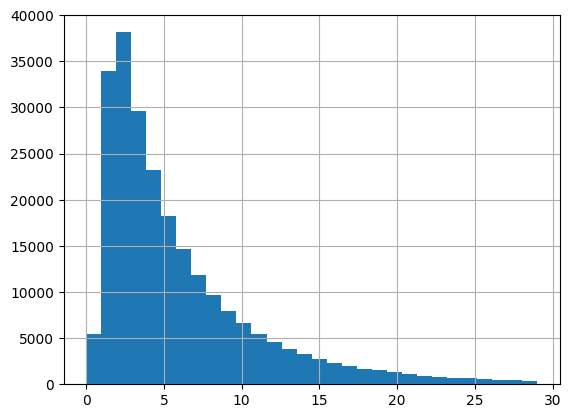

In [6]:
call_len_hist = calls_simple[calls_simple["CallLength"]<30]["CallLength"].hist(bins=30)

In [7]:
calls_frequency = calls_simple.groupby('year')[['CallLength']].count()


In [8]:
calls_simple[calls_simple["CallLength"]>50]

for i in range(10,150,10):
    temp = calls_simple.loc[(calls_simple["CallLength"]>i)]
    print("There are ",len(temp), "calls of length greater than ", i)


There are  38211 calls of length greater than  10
There are  9572 calls of length greater than  20
There are  3177 calls of length greater than  30
There are  1227 calls of length greater than  40
There are  544 calls of length greater than  50
There are  247 calls of length greater than  60
There are  130 calls of length greater than  70
There are  63 calls of length greater than  80
There are  34 calls of length greater than  90
There are  22 calls of length greater than  100
There are  18 calls of length greater than  110
There are  13 calls of length greater than  120
There are  7 calls of length greater than  130
There are  6 calls of length greater than  140


In [9]:
CityName_stats = calls_simple[["CityName","CallLength"]].groupby("CityName").mean()
CityName_stats["count"] = pd.Series(calls_simple[["CityName","CallLength"]].groupby("CityName").count()["CallLength"])
CityName_stats.sort_values(["count"],ascending=False).tail(100)

,CallLength,count
CityName,,
Jasper,11.0,1
Bonnyville,3.0,1
Kemano,6.0,1
Dease Lake,7.0,1
Kildonan,3.0,1
...,...,...
Bridesville,10.0,1
Opasatika,6.0,1
Oyster Bay,8.0,1


In [10]:
total = sum(CityName_stats['count'])
test = sum(CityName_stats[CityName_stats['count'] > 500]["count"])
test/total

#len(CityName_stats[CityName_stats['count'] > 500])


0.9420004543045355

In [11]:
calls_simple = calls_simple.sample(frac=1)

ratio = 0.8
 
total_rows = calls_simple.shape[0]
train_size = int(total_rows*ratio)
 
# Split data into test and train
#train = calls_simple[0:train_size]
#test = calls_simple[train_size:]

#for now all data is test

test = calls_simple.copy()



# Model: Try guessing the year avg

In [24]:
#guess the time based on year avg
test["prediction"] = test["year"].map(lambda x: avg_year.loc[x,"CallLength"])


In [26]:
def check_validity(test_df):
    check_df = test_df.copy()

    check_df["Correct"] = False

    for c in check_df.index:
        truth = check_df.loc[c,"CallLength"]
        pred = check_df.loc[c,"prediction"]

        if pred < (truth + 1) and pred > truth - 1:
             check_df.loc[c,"Correct"] = True
        
    check_df = check_df.groupby("Correct")[["CallLength"]].count()
    print("The accuracy is ",100*check_df.loc[True,"CallLength"]/sum(check_df.loc[:,"CallLength"]), "percent if it just has to be within 1 min. ")
    rmse = mean_squared_error(test['CallLength'], test['prediction'], squared=False)
    print("The rmse is: ", rmse)
    return check_df

check_validity(test)




The accuracy is  11.666792862370965 percent if it just has to be within 1 min. 
The rmse is:  7.120056000998193


,CallLength
Correct,
False,209991
True,27735


In [22]:
# Model: Try guessing the year avg
test["guess"] = test["CityName"].map(lambda x: CityName_stats.loc[x,"CallLength"])


In [23]:
check_validity(test)

The accuracy is  12.72094764560881 percent if it just has to be within 1 min. 
The rmse is:  7.027583116932248


,CallLength
Correct,
False,207485
True,30241


# Random Forest 

In [83]:
#make the training sets
calls_simple = calls_simple.sample(frac=1)


#add code to each city
city_to_code = pd.DataFrame(calls_simple["CityName"].unique())
city_to_code["code"] = pd.Series(range(0,514))
city_to_code.columns = ["CityName","code"]



calls_simple["CityNameCode"] = calls_simple["CityName"].map(lambda x: city_to_code.loc[city_to_code["CityName"] == x,"code"].iloc[0] )

ratio = 0.8
 
total_rows = calls_simple.shape[0]
train_size = int(total_rows*ratio)
 
# Split data into test and train
trainx = calls_simple[0:train_size][["year","CityNameCode"]]
trainy = calls_simple[0:train_size][["CallLength"]]
testx = calls_simple[train_size:][["year","CityNameCode"]]
tesy = calls_simple[train_size:][["CallLength"]]



In [85]:
calls_simple

,callreportnum,DateStart,TimeStart,CityName,ContactMethod,CallLength,year,CityNameCode
155423,80242694.0,2020-10-26,1899-12-31 16:14:00,Port Moody,Telephone,5,2020,0
3896,92547636.0,2021-09-16,1899-12-31 01:02:00,Vancouver,Telephone,2,2021,1
197913,91733222.0,2021-08-25,1899-12-31 15:33:00,White Rock,Telephone,9,2021,2
116580,68777858.0,2019-12-05,1899-12-31 08:39:00,Vancouver,Telephone,2,2019,1
14425,59577126.0,2019-01-18,1899-12-31 14:07:00,Richmond,Telephone,8,2019,3
...,...,...,...,...,...,...,...,...
44593,61931158.0,2019-04-06,1899-12-31 11:11:00,Surrey,Text Message,1,2019,8
51484,62264314.0,2019-04-18,1899-12-31 15:21:00,unknown,Text Message,1,2019,4
105286,66519451.0,2019-09-20,1899-12-31 18:09:00,Surrey,Text Message,1,2019,8
28498,56499220.0,2018-09-22,1899-12-31 17:06:00,New Westminster,Telephone,27,2018,9


In [89]:
sel = RandomForestClassifier(n_estimators = 100)
sel.fit(trainx,np.ravel(trainy)) 

RandomForestClassifier()

In [91]:
y_pred = sel.predict(testx)


[2 1 2 ... 2 2 3]


In [92]:
accuracy = accuracy_score(tesy, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.1715601733058512


In [98]:

for i in range(3):
    tree = sel.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=trainx.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [77]:
sel.get_support()

selected_feat= trainx.columns[(sel.get_support())]
len(selected_feat)

1

Index(['CityNameCode'], dtype='object')


<Axes: >

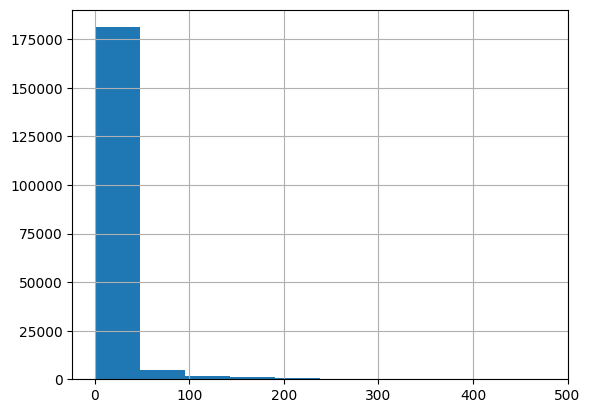

In [81]:
print(selected_feat)
pd.Series(trainx["CityNameCode"].ravel()).hist()
